# DataFlowTasks.jl

[![Stable](https://img.shields.io/badge/docs-stable-blue.svg)](https://maltezfaria.github.io/DataFlowTasks.jl/stable)
[![Dev](https://img.shields.io/badge/docs-dev-blue.svg)](https://maltezfaria.github.io/DataFlowTasks.jl/dev)
[![Build
Status](https://github.com/maltezfaria/DataFlowTasks.jl/workflows/CI/badge.svg)](https://github.com/maltezfaria/DataFlowTasks.jl/actions)
[![codecov](https://codecov.io/gh/maltezfaria/DataFlowTasks.jl/branch/main/graph/badge.svg?token=UOWU691WWG)](https://codecov.io/gh/maltezfaria/DataFlowTasks.jl)
![Lifecycle](https://img.shields.io/badge/lifecycle-experimental-blue.svg)

`DataFlowTasks.jl` is a Julia package dedicated to parallel programming on multi-core shared memory CPUs. From user annotations (READ, WRITE, READWRITE) on program data, `DataFlowTasks.jl` automatically infers dependencies between parallel tasks.

`DataFlowTasks.jl` is particularly easy to use with programs manipulating Julia
arrays, but can be extended to work with any custom data structure.

## Installation

```julia
using Pkg
Pkd.add("https://github.com/maltezfaria/DataFlowTasks.jl.git")
```

## Basic Usage

The use of `DataFlowTask`s is intended to be as similar to Julia native `Task`s as possible. The API implements three macros :

- `@dspawn`
- `@dtask`
- `@dasync`

which behave like their `Base` counterparts, except they need additional annotations to specify access modes. This is done with the three macros :

* `@R`
* `@W`
* `@RW`

where, in a function argument or at the beginning of a task block, `@R(A)` implies that A will be in read mode in the function/block.

Let's look at a simple example:

In [1]:
using DataFlowTasks
DataFlowTasks.reset!() #hide
A = Vector{Float64}(undef, 4)
result = let
    @dspawn fill!(@W(A), 0)           # task 1: accesses everything
    @dspawn @RW(view(A, 1:2)) .+= 2   # task 2: modifies the first half
    @dspawn @RW(view(A, 3:4)) .+= 3   # task 3: modifies the second half
    @dspawn @R(A)                     # task 4: get the result
end
fetch(result)

4-element Vector{Float64}:
 2.0
 2.0
 3.0
 3.0

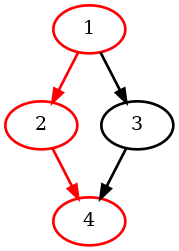

In [2]:
using GraphViz
DataFlowTasks.dagplot()

This will generate the DAG (Directed Acyclic Graph) above that represents the dependencies between tasks. This means that the task 2 and 3 can be run in parallel. We see how it's the memory that matters here.

## Example : Parallel Cholesky Factorization

As a less contrived example, we illustrate below the use of `DataFlowTasks` to parallelize a tiled Cholesky factorization. The implementation shown here is delibarately made as simple as possible; a more complex and more efficient implementation can be found in the [TiledFactorization](https://github.com/maltezfaria/TiledFactorization) package.

The Cholesky factorization algorithm takes a symmetric positive definite matrix A and finds a lower triangular matrix L such that `A = LLᵀ`. The tiled version of this algorithm decomposes the matrix A into tiles (of even sizes, in this simplified version). At each step of the algorithm, we do a Cholesky factorization on the diagonal tile, use a triangular solve to update all of the tiles at the right of the diagonal tile, and finally update all the tiles of the submatrix with a schur complement.

If we have a matrix A decomposed in `n x n` tiles, then the algorithm will have `n` steps. The `i`-th step (with `i ∈ [1:n]`) will perform
- `1` cholesky factorization of the (i,i) block (I),
- `(i-1)` triangular solves (one for each block in the `i`-th row) (II),
- `i*(i-1)/2` matrix multiplications to update the submatrix (III).

We illustrate the 2nd step of the algorithm in the following image.

![](Cholesky_2ndStep.png)

A sequential tiled factorization algorithm can be implemented as:

In [3]:
using LinearAlgebra
tilerange(ti, ts) = (ti-1)*ts+1:ti*ts
function cholesky_tiled!(A, ts)
    m = size(A, 1); @assert m==size(A, 2)
    m%ts != 0 && error("Tilesize doesn't fit the matrix")
    n = m÷ts  # number of tiles in each dimension

    T = [view(A, tilerange(i, ts), tilerange(j, ts)) for i in 1:n, j in 1:n]

    for i in 1:n
        # Diagonal cholesky serial factorization (I)
        cholesky!(T[i,i])

        # Left blocks update (II)
        U = UpperTriangular(T[i,i])
        for j in i+1:n
            ldiv!(U', T[i,j])
        end

        # Submatrix update (III)
        for j in i+1:n
            for k in j:n
                mul!(T[j,k], T[i,j]', T[i,k], -1, 1)
            end
        end
    end

    # Construct the factorized object
    return Cholesky(A, 'U', zero(LinearAlgebra.BlasInt))
end

cholesky_tiled! (generic function with 1 method)

In order to parallelize the code with DataFlowTasks, it will only be necessary to wrap function calls within a `@dspawn`, and add a synchronization point at the end. The parallelized code will be :

In [4]:
using DataFlowTasks

function cholesky_dft!(A, ts)
    m = size(A, 1); @assert m==size(A, 2)
    m%ts != 0 && error("Tilesize doesn't fit the matrix")
    n = m÷ts  # number of tiles in each dimension

    T = [view(A, tilerange(i, ts), tilerange(j, ts)) for i in 1:n, j in 1:n]

    for i in 1:n
        # Diagonal cholesky serial factorization (I)
        @dspawn cholesky!(@RW(T[i,i])) label="chol ($i,$i)"

        # Left blocks update (II)
        U = UpperTriangular(T[i,i])
        for j in i+1:n
            @dspawn ldiv!(@R(U)', @RW(T[i,j])) label="ldiv ($i,$j)"
        end

        # Submatrix update (III)
        for j in i+1:n
            for k in j:n
                @dspawn mul!(@RW(T[j,k]), @R(T[i,j])', @R(T[i,k]), -1, 1) label="schur ($j,$k)"
            end
        end
    end

    # Construct the factorized object
    r = @dspawn Cholesky(@R(A), 'U', zero(LinearAlgebra.BlasInt)) label="result"
    return fetch(r)
end

cholesky_dft! (generic function with 1 method)

The code below shows how to use this `cholesky_tiled!` function, how to profile the program and get the most information from the visualization.

In [5]:
import DataFlowTasks as DFT

# DataFlowTasks environnement setup
DFT.reset!()
DFT.enable_log()

# Context
n  = 2048
ts = 512
A = rand(n, n)
A = (A + adjoint(A))/2
A = A + n*I;

In [6]:
@info "Testing sequential Cholesky factorization"          #hide
F = cholesky_tiled!(copy(A), ts)                           #hide
err = norm(F.L*F.U-A,Inf)/max(norm(A),norm(F.L*F.U))       #hide
@show err                                                  #hide
@assert err < eps(Float64)                                 #hide

[ Info: Testing sequential Cholesky factorization
err = 9.809986122962574e-18


In [7]:
@info "Testing parallel Cholesky factorization" #hide

# First run to trigger compilation
F = cholesky_dft!(copy(A), ts)

# Check results
err = norm(F.L*F.U-A,Inf)/max(norm(A),norm(F.L*F.U))
@show err                   #hide
@assert err < eps(Float64)  #hide

[ Info: Testing parallel Cholesky factorization
err = 9.809986122962574e-18


## Profiling

DataFlowTasks comes with 2 main profiling tools whose outputs for the case presented above are as follows :

In [8]:
# Reset profiling environnement
DFT.resetlogger!()
GC.gc()

# Real workload to be analysed
cholesky_dft!(A ,ts);

The DAG represents dependencies between tasks, as inferred by `DataFlowTasks` from the task-data dependencies. The critical path (i.e. the longest sequential path in the graph) is plotted in red; il can be a limiting factor of the overall performance of the algorithm.

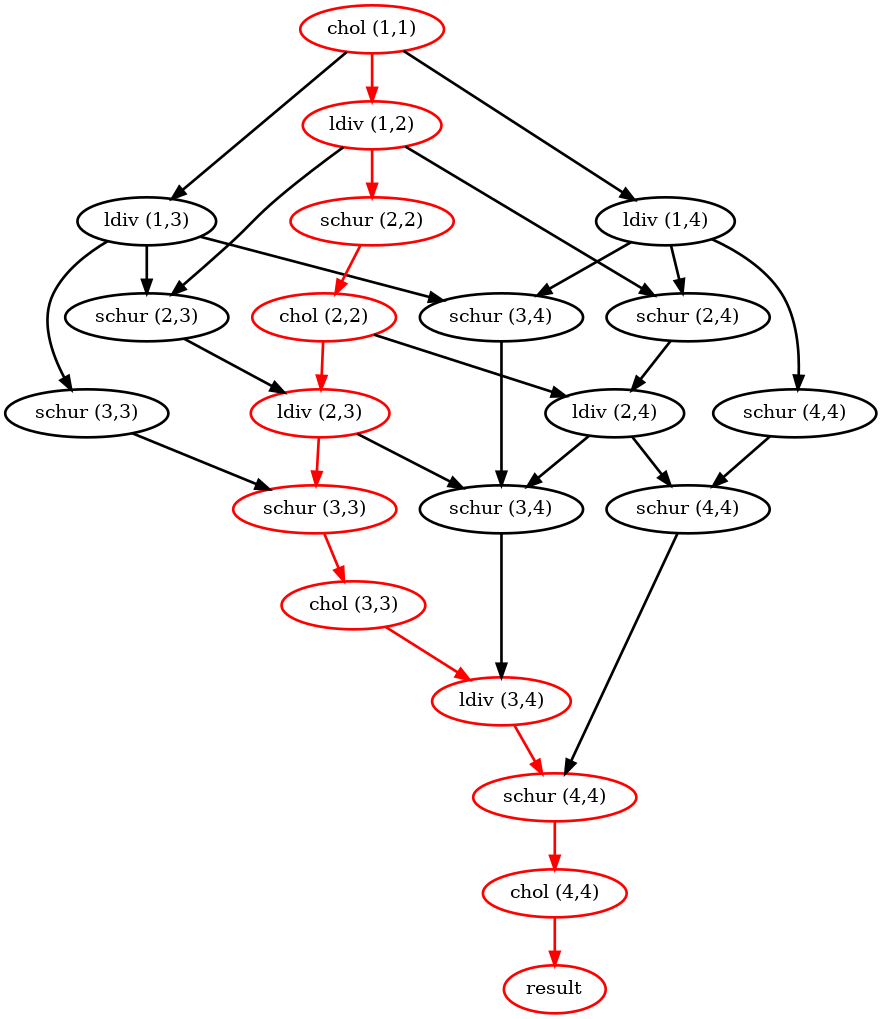

In [9]:
using GraphViz
dag = DFT.dagplot()

The parallel trace plots a timeline of the tasks execution on the available threads. It also carries other general information allowing to better understand the performance limiting factors:

[ Info: Computing    : 0.1475834970000001
[ Info: Inserting    : 4.322200000000003e-5
[ Info: Other        : 0.07410321300365447


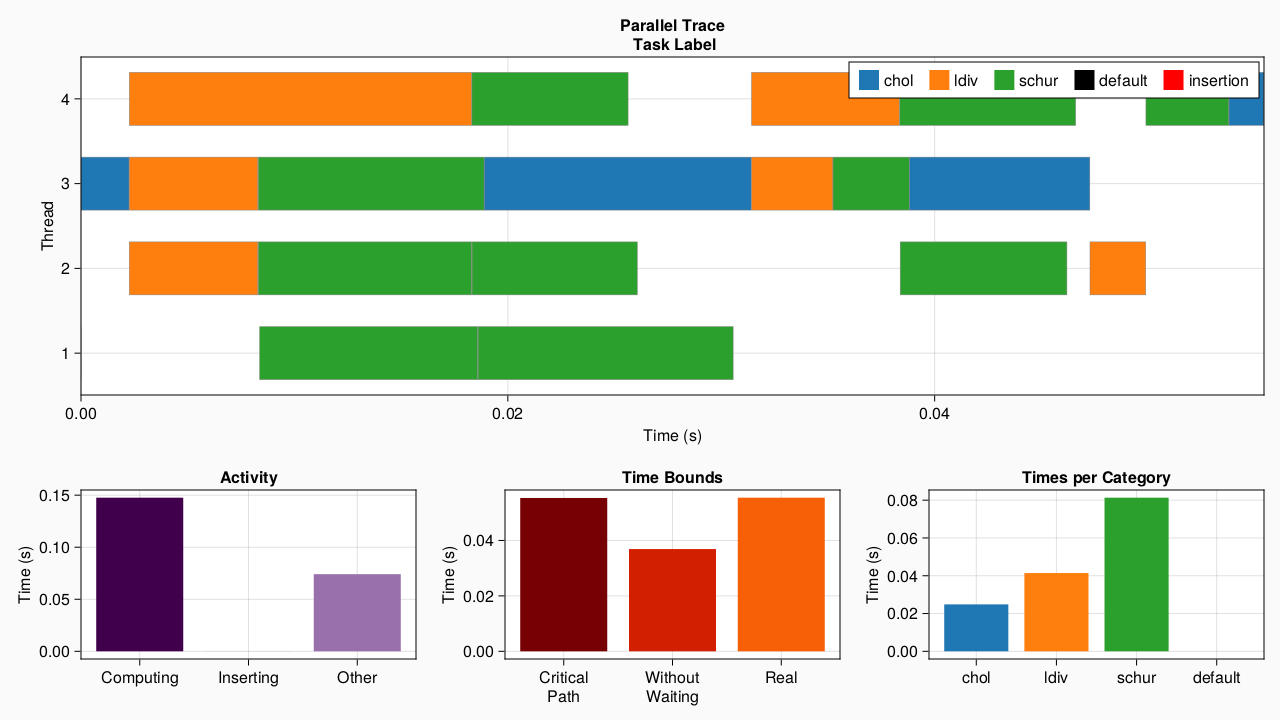

In [10]:
using CairoMakie # or GLMakie in order to have more interactivity
trace = DFT.plot(categories=["chol", "ldiv", "schur"])

We see here that the execution time is bounded by the length of the critical path: with this block size and matrix size, the algorithm does not expose enough parallelism to occupy all threads without waiting periods.

We'll cover in details the usage and possibilities of the visualization in the documentation.

Note that the visualization tools are not loaded by default, as they require additional dependencies (a `Makie` backend and/or `GraphViz`) to be loaded in the REPL. These features are meant to only be used in development, so they aren't declared as hard dependencies in order to avoid polluting the environment you want to use `DataFlowTasks` in.

# Performances

The following results are obtained with a slightly modified version of the function presented above. We used the `LoopVectorization` for the serial cholesky (I), `TriangularSolve`'s `ldiv!` and `Octavian`'s `matmul_serial!`.

The package `TiledFactorization` contains this implementation, you can use it with the following lines :

```julia
import Pkg
Pkg.add("https://github.com/maltezfaria/TiledFactorization.git")
using TiledFactorization: cholesky!
```

We compare the performances achieved with this version of the Cholesky factorization with the MKL one, and we obtain the next figure. Here the blocks are of size (256, 256).

![](scalability_lfaria.png)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*